In [8]:
import torch
import torch.nn as nn
from dataloaders import load_cifar10
from trainer import Trainer, compute_loss_and_accuracy
from task2 import create_plots

In [16]:
class Model1(nn.Module):

    def __init__(self,
                 image_channels,
                 num_classes):
        """
            Is called when model is initialized.
            Args:
                image_channels. Number of color channels in image (3)
                num_classes: Number of classes we want to predict (10)
        """
        super().__init__()
        # TODO: Implement this function (Task  2a)
        num_filters = 50  # Set number of filters in first conv layer
        dim_imag = 32 #Dimension of the images in input
        
        kern_conv = 5
        stride_conv = 1
        pad_conv = 2
        
        kern_pool = 2
        stride_pool= 2
        self.num_classes = num_classes
        pool = nn.MaxPool2d(
                    kernel_size=kern_pool,
                    stride=stride_pool
                )
        # Define the convolutional layers
        
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(
                    in_channels=image_channels,
                    out_channels=num_filters,
                    kernel_size=kern_conv,
                    stride=stride_conv,
                    padding=pad_conv
                ),
            nn.BatchNorm2d(num_filters),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(
                    kernel_size=kern_pool,
                    stride=stride_pool
                ),
            nn.Conv2d(
                in_channels=num_filters,
                out_channels=2*num_filters,
                kernel_size=kern_conv,
                stride=stride_conv,
                padding=pad_conv
            ),
            nn.BatchNorm2d(2*num_filters),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(
                    kernel_size=kern_pool,
                    stride=stride_pool
                ),
            nn.Conv2d(
                in_channels=2*num_filters,
                out_channels=4*num_filters,
                kernel_size=kern_conv,
                stride=stride_conv,
                padding=pad_conv
            ),
            nn.BatchNorm2d(4*num_filters),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(
                    kernel_size=kern_pool,
                    stride=stride_pool
            )
        )
        
        # The output of feature_extractor will be [batch_size, num_filters, 4, 4]
        self.num_output_features = 4*4
        # Initialize our last fully connected layer
        # Inputs all extracted features from the convolutional layers
        # Outputs num_classes predictions, 1 for each class.
        # There is no need for softmax activation function, as this is
        # included with nn.CrossEntropyLoss
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.num_output_features*4*num_filters, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes),
            nn.BatchNorm1d(num_classes)
        )

    def forward(self, x):
        """
        Performs a forward pass through the model
        Args:
            x: Input image, shape: [batch_size, 3, 32, 32]
        """
        # TODO: Implement this function (Task  2a)
        batch_size = x.shape[0]
        feature =  self.feature_extractor(x)
        out = self.classifier(feature)
        expected_shape = (batch_size, self.num_classes)
        assert out.shape == (batch_size, self.num_classes),\
            f"Expected output of forward pass to be: {expected_shape}, but got: {out.shape}"
        return out
    
    
#Initialization of weights
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        print("Weight init")
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_in', 
                                nonlinearity='relu')
        m.bias.data.fill_(0.0)

In [17]:
epochs = 10
batch_size = 64
learning_rate = 8e-3
early_stop_count = 4

dataloaders = load_cifar10(batch_size)
model1 = Model1(image_channels=3, num_classes=10)
#Initialization of weights
model1.apply(init_weights)
trainer1 = Trainer(
    batch_size,
    learning_rate,
    early_stop_count,
    epochs,
    model1,
    dataloaders
)
# Applying it to our net
trainer1.train()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Weight init
Weight init
Weight init
Weight init
Weight init
Model1(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.2, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(50, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (6): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Dropout(p=0.2, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(100, 200, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (11): BatchNorm2d(200, eps=1e-05, momentum=0.1

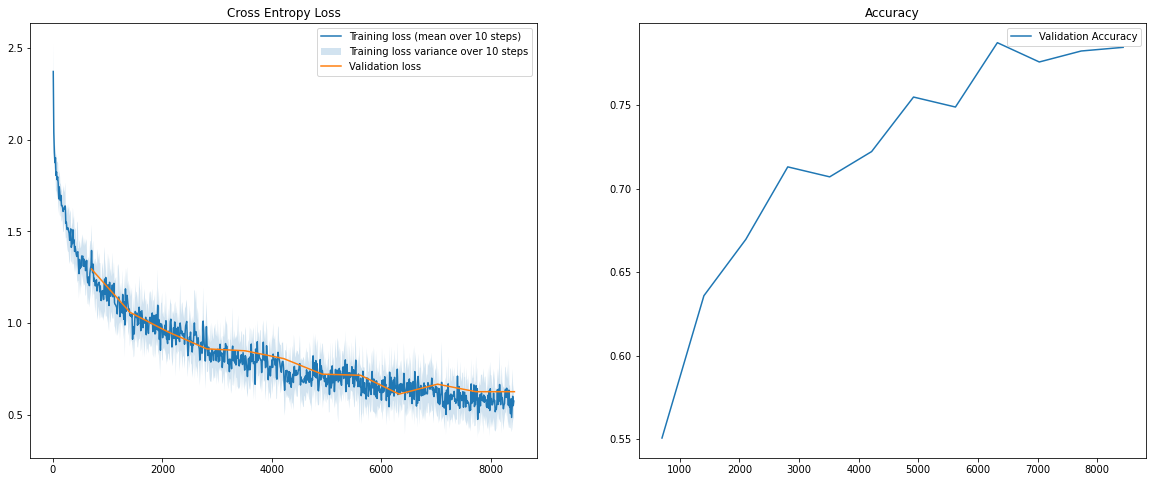

In [18]:
create_plots(trainer1, "task3_1_leaky")

In [19]:
print(compute_loss_and_accuracy(trainer1.dataloader_train, trainer1.model, trainer1.loss_criterion))
print(compute_loss_and_accuracy(trainer1.dataloader_val, trainer1.model, trainer1.loss_criterion))
print(compute_loss_and_accuracy(trainer1.dataloader_test, trainer1.model, trainer1.loss_criterion))

(0.5488719116806305, 0.8118554409672831)
(0.6912443468904799, 0.7641321656050956)
(0.7135573891317768, 0.767515923566879)


# Model 2

In [36]:
class Model2(nn.Module):

    def __init__(self,
                 image_channels,
                 num_classes):
        """
            Is called when model is initialized.
            Args:
                image_channels. Number of color channels in image (3)
                num_classes: Number of classes we want to predict (10)
        """
        super().__init__()
        # TODO: Implement this function (Task  2a)
        num_filters = 50  # Set number of filters in first conv layer
        dim_imag = 32 #Dimension of the images in input
        
        kern_conv = 3
        stride_conv = 1
        pad_conv = 1
        
        kern_pool = 2
        stride_pool= 2
        self.num_classes = num_classes
        pool = nn.MaxPool2d(
                    kernel_size=kern_pool,
                    stride=stride_pool
                )
        # Define the convolutional layers
        
        self.feature_extractor = nn.Sequential(
            #1
            nn.Conv2d(
                    in_channels=image_channels,
                    out_channels=num_filters,
                    kernel_size=kern_conv,
                    stride=stride_conv,
                    padding=pad_conv
                ),
            nn.BatchNorm2d(num_filters),
            nn.LeakyReLU(),
            nn.Conv2d(
                    in_channels=num_filters,
                    out_channels=num_filters,
                    kernel_size=kern_conv,
                    stride=stride_conv,
                    padding=pad_conv
                ),
            nn.BatchNorm2d(num_filters),
            nn.LeakyReLU(),
            nn.MaxPool2d(
                    kernel_size=kern_pool,
                    stride=stride_pool
                ),
             nn.Dropout(0.2),
            #2
            nn.Conv2d(
                    in_channels=num_filters,
                    out_channels=2*num_filters,
                    kernel_size=kern_conv,
                    stride=stride_conv,
                    padding=pad_conv
                ),
            nn.BatchNorm2d(2*num_filters),
            nn.LeakyReLU(),
            nn.Conv2d(
                    in_channels=2*num_filters,
                    out_channels=2*num_filters,
                    kernel_size=kern_conv,
                    stride=stride_conv,
                    padding=pad_conv
                ),
            nn.BatchNorm2d(2*num_filters),
            nn.LeakyReLU(),
            nn.MaxPool2d(
                    kernel_size=kern_pool,
                    stride=stride_pool
                ),
             nn.Dropout(0.2),
            #3
            nn.Conv2d(
                    in_channels=2*num_filters,
                    out_channels=4*num_filters,
                    kernel_size=kern_conv,
                    stride=stride_conv,
                    padding=pad_conv
                ),
            nn.BatchNorm2d(4*num_filters),
            nn.LeakyReLU(),
            nn.Conv2d(
                    in_channels=4*num_filters,
                    out_channels=4*num_filters,
                    kernel_size=kern_conv,
                    stride=stride_conv,
                    padding=pad_conv
                ),
            nn.BatchNorm2d(4*num_filters),
            nn.LeakyReLU(),
            nn.MaxPool2d(
                    kernel_size=kern_pool,
                    stride=stride_pool
                ),
            nn.Dropout(0.2)
        )
        
        # The output of feature_extractor will be [batch_size, num_filters, 4, 4]
        self.num_output_features = 4*4
        # Initialize our last fully connected layer
        # Inputs all extracted features from the convolutional layers
        # Outputs num_classes predictions, 1 for each class.
        # There is no need for softmax activation function, as this is
        # included with nn.CrossEntropyLoss
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.num_output_features*4*num_filters, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes),
            nn.BatchNorm1d(num_classes)
        )
    

    def forward(self, x):
        """
        Performs a forward pass through the model
        Args:
            x: Input image, shape: [batch_size, 3, 32, 32]
        """
        # TODO: Implement this function (Task  2a)
        batch_size = x.shape[0]
        feature =  self.feature_extractor(x)
        out = self.classifier(feature)
        expected_shape = (batch_size, self.num_classes)
        assert out.shape == (batch_size, self.num_classes),\
            f"Expected output of forward pass to be: {expected_shape}, but got: {out.shape}"
        return out
    
    
#Initialization of weights
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        print("Weight init")
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_in', 
                                nonlinearity='relu')
        m.bias.data.fill_(0.0)

In [37]:
epochs = 10
batch_size = 64
learning_rate = 8e-2
early_stop_count = 4

dataloaders = load_cifar10(batch_size)

model2 = Model2(image_channels=3, num_classes=10)
#Initialization of weights
model2.apply(init_weights)
trainer2 = Trainer(
    batch_size,
    learning_rate,
    early_stop_count,
    epochs,
    model2,
    dataloaders
)
trainer2.train()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Weight init
Weight init
Weight init
Weight init
Weight init
Weight init
Weight init
Weight init
Model2(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): 

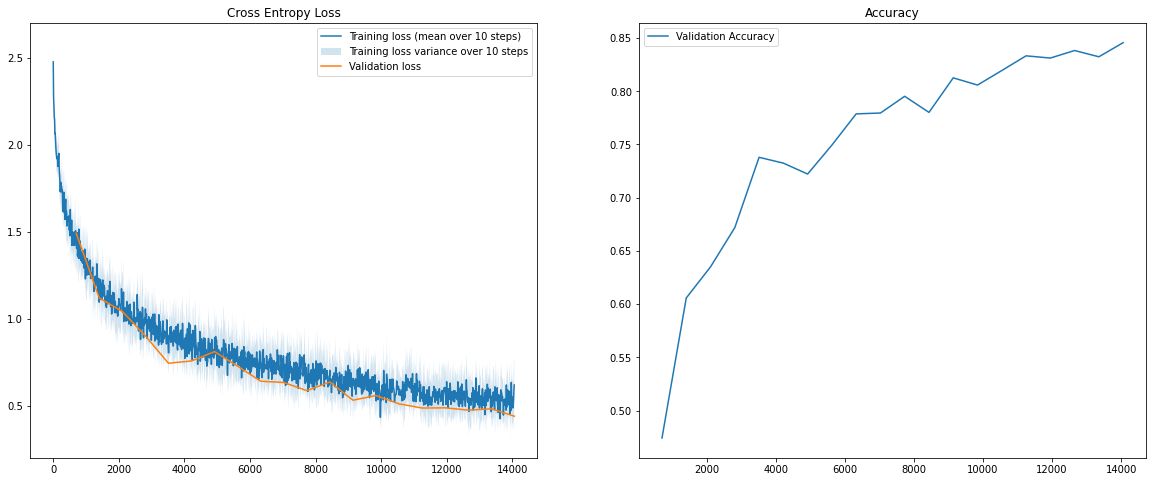

In [38]:
create_plots(trainer2, "task3_2_dropout_leaky_no batch")

In [39]:
print(compute_loss_and_accuracy(trainer2.dataloader_train, trainer2.model, trainer2.loss_criterion))
print(compute_loss_and_accuracy(trainer2.dataloader_val, trainer2.model, trainer2.loss_criterion))
print(compute_loss_and_accuracy(trainer2.dataloader_test, trainer2.model, trainer2.loss_criterion))

(0.499352069701443, 0.8296586059743954)
(0.5899435247585272, 0.7976711783439491)
(0.5840557307764224, 0.8126990445859873)


# Model 3

In [ ]:
class Model3(nn.Module):

    def __init__(self,
                 image_channels,
                 num_classes):
        """
            Is called when model is initialized.
            Args:
                image_channels. Number of color channels in image (3)
                num_classes: Number of classes we want to predict (10)
        """
        super().__init__()
        # TODO: Implement this function (Task  2a)
        num_filters = 50  # Set number of filters in first conv layer
        dim_imag = 32 #Dimension of the images in input
        
        kern_conv = 4
        stride_conv = 2
        pad_conv = 1
        
        kern_pool = 2
        stride_pool= 2
        self.num_classes = num_classes
        pool = nn.MaxPool2d(
                    kernel_size=kern_pool,
                    stride=stride_pool
                )
        # Define the convolutional layers
        
        self.feature_extractor = nn.Sequential(
            #1
            nn.BatchNorm2d(image_channels),
            nn.LeakyReLU(),
            nn.Conv2d(
                    in_channels=image_channels,
                    out_channels=num_filters,
                    kernel_size=5,
                    stride=1,
                    padding=2
                ),
            #2
            nn.BatchNorm2d(num_filters),
            nn.LeakyReLU(),
            nn.Conv2d(
                    in_channels=num_filters,
                    out_channels=2*num_filters,
                    kernel_size=3,
                    stride=1,
                    padding=1
                ),
            #3
            nn.BatchNorm2d(2*num_filters),
            nn.LeakyReLU(),
            nn.Conv2d(
                    in_channels=2*num_filters,
                    out_channels=2*num_filters,
                    kernel_size=kern_conv,
                    stride=stride_conv,
                    padding=pad_conv
                ),
            #4
            nn.BatchNorm2d(2*num_filters),
            nn.LeakyReLU(),
            nn.Conv2d(
                    in_channels=2*num_filters,
                    out_channels=4*num_filters,
                    kernel_size=kern_conv,
                    stride=stride_conv,
                    padding=pad_conv
                ),
            #5
            nn.BatchNorm2d(4*num_filters),
            nn.LeakyReLU(),
            nn.Conv2d(
                    in_channels=4*num_filters,
                    out_channels=4*num_filters,
                    kernel_size=kern_conv,
                    stride=stride_conv,
                    padding=pad_conv
                )
        )
        
        # The output of feature_extractor will be [batch_size, num_filters, 4, 4]
        self.num_output_features = 4*4
        # Initialize our last fully connected layer
        # Inputs all extracted features from the convolutional layers
        # Outputs num_classes predictions, 1 for each class.
        # There is no need for softmax activation function, as this is
        # included with nn.CrossEntropyLoss
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.num_output_features*4*num_filters, 64),
            nn.Dropout(0.2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
            nn.BatchNorm1d(num_classes)
        )

    def forward(self, x):
        """
        Performs a forward pass through the model
        Args:
            x: Input image, shape: [batch_size, 3, 32, 32]
        """
        # TODO: Implement this function (Task  2a)
        batch_size = x.shape[0]
        feature =  self.feature_extractor(x)
        out = self.classifier(feature)
        expected_shape = (batch_size, self.num_classes)
        assert out.shape == (batch_size, self.num_classes),\
            f"Expected output of forward pass to be: {expected_shape}, but got: {out.shape}"
        return out
    
    
#Initialization of weights
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        print("Weight init")
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_in', 
                                nonlinearity='relu')
        m.bias.data.fill_(0.0)

In [ ]:
epochs = 10
batch_size = 64
learning_rate = 8e-2
early_stop_count = 4

dataloaders = load_cifar10(batch_size)

model3 = Model3(image_channels=3, num_classes=10)
#Initialization of weights
model3.apply(init_weights)
trainer3 = Trainer(
    batch_size,
    learning_rate,
    early_stop_count,
    epochs,
    model3,
    dataloaders
)
trainer3.train()

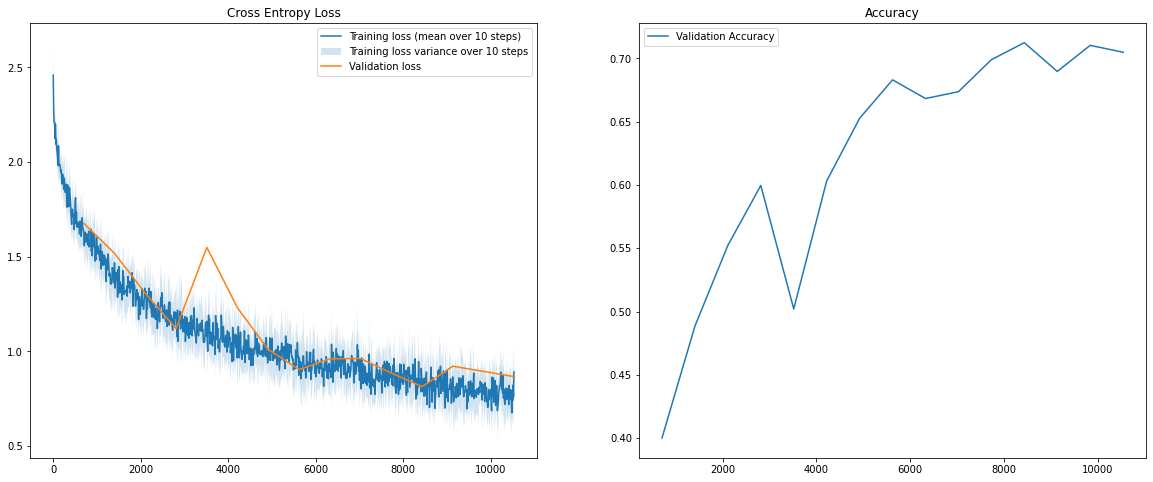

In [14]:
create_plots(trainer3, "task3_3_leaky_dropout")

In [15]:
print(compute_loss_and_accuracy(trainer3.dataloader_train, trainer3.model, trainer3.loss_criterion))
print(compute_loss_and_accuracy(trainer3.dataloader_val, trainer3.model, trainer3.loss_criterion))
print(compute_loss_and_accuracy(trainer3.dataloader_test, trainer3.model, trainer3.loss_criterion))

(0.7713918050229126, 0.7276626955903271)
(0.8652002057831758, 0.7010350318471338)
(0.7894659989578708, 0.7273089171974523)
